<a href="https://colab.research.google.com/github/ahmedbasemdev/Neural-Machine-Translation/blob/main/Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Translation
    
    
Our model consists of two parts : An encoder which maps source-text into a vector " summarizes text's content " , which is the input to second part decoder which decodes the vector to destination-text

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
cd "/content/drive/MyDrive/Machine Translation"

/content/drive/MyDrive/Machine Translation


In [ ]:
ls

21_checkpoint.h5  Code.ipynb  europarl-v7.da-en.da  model.png  tblogs/
21_logs/          da-en.tar   europarl-v7.da-en.en  README.md


## Imports

In [ ]:
import os
import math
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
%matplotlib inline

In [ ]:
from tensorflow.keras.models import Model , load_model
from tensorflow.keras.layers import Input , Dense, GRU , Embedding
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping , ModelCheckpoint , TensorBoard
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
tf.__version__

'2.8.2'

In [ ]:
tf.keras.__version__

'2.8.0'

## Load Data 

In [ ]:
startMark = "ssss "
endMark = " eeee"

In [ ]:
#!wget https://www.statmt.org/europarl/v7/da-en.tgz

In [ ]:
#!gunzip "/content/drive/MyDrive/Machine Translation/da-en.tgz"
#!tar -xvf "/content/drive/MyDrive/Machine Translation/da-en.tar"

In [ ]:
with open('/content/drive/MyDrive/Machine Translation/europarl-v7.da-en.da',encoding='utf-8') as f:
    dataSrc = [ line.strip() for line in f ]

In [ ]:
with open('/content/drive/MyDrive/Machine Translation/europarl-v7.da-en.en',encoding='utf-8') as f:
    dataDest = [startMark + line.strip() + endMark for line in f ]

In [ ]:
len(dataSrc)

1968800

Our data takes 30 hour per epoch to train , which is very much time , so we slice our data and take first 50000 line

In [ ]:
numberofLines = int(len(dataSrc) / 4)
numberofLines

492200

In [ ]:
dataSrc = dataSrc[:numberofLines]

In [ ]:
dataDest = dataDest[:numberofLines]

In [ ]:
dataSrc[2]

'Som De kan se, indfandt det store "år 2000-problem" sig ikke. Til gengæld har borgerne i en del af medlemslandene været ramt af meget forfærdelige naturkatastrofer.'

In [ ]:
dataDest[2]

"ssss Although, as you will have seen, the dreaded 'millennium bug' failed to materialise, still the people in a number of countries suffered a series of natural disasters that truly were dreadful. eeee"

We need a few more functions than provided by Keras' Tokenizer-class so we wrap it.


In [ ]:
num_words = 10000

In [ ]:
class TokenizerWrap(Tokenizer):
    
    def __init__(self,texts,padding , reverse=False, num_words=None):
        
        
        Tokenizer.__init__(self,num_words=num_words)
        
        self.fit_on_texts(texts)
        
        self.index_to_word = dict(zip(self.word_index.values(),
                                      self.word_index.keys()))
        
        self.tokens = self.texts_to_sequences(texts)
        
        
        if reverse :
            # reversing token-sequence
            self.tokens = [list(reversed(x)) for x in self.tokens]
            # sequence that are too long should be trucated at the beginning
            # "which correspond to the end of original sequence" 
            truncating = 'pre'
        else:
            # sequence that are too long should be trucated at the end
            truncating = 'post'
        self.numTokens = [len(x) for x in self.tokens]
        # mean + 2 * std = Around 95% "only have to truncate 5% of all sequences"
        self.maxTokens = np.mean(self.numTokens) + 2 * np.std(self.numTokens)
        
        self.maxTokens = int(self.maxTokens)
        
        self.tokenPadded = pad_sequences(self.tokens , maxlen = self.maxTokens ,
                                         padding = padding ,truncating=truncating)
        
    def token_to_word(self,token):
        """ Lookup a single word from a token
        """
        return " " if token ==0 else self.index_to_word[token]
        
    def tokens_to_string(self,tokens):
        """Convert a list of tokens to a string"""
        text = [self.index_to_word[token] 
                    for token in tokens
                    if token != 0]
        text = " ".join(text)
        return text

    def text_to_tokens(self,text,reverse=False, padding=False):
        """Convert a string to a list of tokens"""
        tokens = self.texts_to_sequences([text])
        tokens = np.array(tokens)

        if reverse:
            tokens =np.flip(tokens, axis = 1)

            truncating = 'pre'
        else:
            truncating = 'post'

        if padding :
            tokens = pad_sequences(tokens , maxlen=self.maxTokens ,
                                   truncating=truncating ,padding='pre')

        return tokens


Note that we pad zeros at the beginning ('pre') of the sequences. We also reverse the sequences of tokens because the research literature suggests that this might improve performance, because the last words seen by the encoder match the first words produced by the decoder, so short-term dependencies are supposedly modelled more accurately.

In [ ]:
%%time
tokenizerSrc = TokenizerWrap(texts=dataSrc,
                              padding='pre',
                              reverse=True,
                              num_words=num_words)

CPU times: user 32.4 s, sys: 276 ms, total: 32.7 s
Wall time: 32.6 s


In [ ]:
%%time
tokenizerDest = TokenizerWrap(texts=dataDest,
                              padding='post',
                              reverse=False,
                              num_words=num_words)

CPU times: user 22.7 s, sys: 258 ms, total: 22.9 s
Wall time: 23.1 s


In [ ]:
tokenSrc = tokenizerSrc.tokenPadded
tokenDest = tokenizerDest.tokenPadded
print(f'The shape of Source tokens is {tokenSrc.shape}')
print(f'The shape of Destination tokens is {tokenDest.shape}')

The shape of Source tokens is (492200, 49)
The shape of Destination tokens is (492200, 57)


In [ ]:
startMark.strip()

'ssss'

In [ ]:
startToken = tokenizerDest.word_index[startMark.strip()]
startToken

2

This is the integer used to mark the beginning of the sentence in destination language

In [ ]:
endToken = tokenizerDest.word_index[endMark.strip()]
endToken

3

### Example of Tokens 

In [ ]:
idx = 2

In [ ]:
tokenSrc[idx]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0, 4679, 2923,   42,    7, 1676,  104, 1637,    7,  172,   10,
          3,  324,   20, 1649,    8,   19,   36,  298,  263,   67,  136,
          5,  198,   24,    9,   11], dtype=int32)

Note how it is padded with zero at the beginning

In [ ]:
tokenizerSrc.tokens_to_string(tokenSrc[idx])

'naturkatastrofer forfærdelige meget af ramt været medlemslandene af del en i borgerne har gengæld til ikke sig problem 2000 år store det se kan de som'

In [ ]:
dataSrc[idx]

'Som De kan se, indfandt det store "år 2000-problem" sig ikke. Til gengæld har borgerne i en del af medlemslandene været ramt af meget forfærdelige naturkatastrofer.'

In [ ]:
tokenDest[idx]

array([   2,  347,   19,   43,   26,   20,  601,    1, 1502,    5,  167,
          1,   81,    7,   10,  204,    4,   67, 2270,   10, 1441,    4,
       1158, 2020,    8, 1608,  109, 5018,    3,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0], dtype=int32)

In [ ]:
tokenizerDest.tokens_to_string(tokenDest[idx])

'ssss although as you will have seen the failed to still the people in a number of countries suffered a series of natural disasters that truly were dreadful eeee'

In [ ]:
dataDest[idx]

"ssss Although, as you will have seen, the dreaded 'millennium bug' failed to materialise, still the people in a number of countries suffered a series of natural disasters that truly were dreadful. eeee"

In [ ]:
tokenizerSrc.text_to_tokens(dataSrc[3])

array([[   9,   20, 2365,  549,   16,   10,  351,   16,   30,  445,    3,
         806,    7, 6457]])

## Training Data

In [ ]:
encoderInputData = tokenSrc
encoderInputData.shape

(492200, 49)

In [ ]:
decoderInputData = tokenDest[:,:-1]
decoderInputData.shape

(492200, 56)

In [ ]:
decoderOutData = tokenDest[:,1:]
decoderOutData.shape

(492200, 56)

In [ ]:
idx = 2

In [ ]:
decoderInputData[idx]

array([   2,  347,   19,   43,   26,   20,  601,    1, 1502,    5,  167,
          1,   81,    7,   10,  204,    4,   67, 2270,   10, 1441,    4,
       1158, 2020,    8, 1608,  109, 5018,    3,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0], dtype=int32)

In [ ]:
decoderOutData[idx]

array([ 347,   19,   43,   26,   20,  601,    1, 1502,    5,  167,    1,
         81,    7,   10,  204,    4,   67, 2270,   10, 1441,    4, 1158,
       2020,    8, 1608,  109, 5018,    3,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0], dtype=int32)

In [ ]:
tokenizerDest.tokens_to_string(decoderInputData[idx])

'ssss although as you will have seen the failed to still the people in a number of countries suffered a series of natural disasters that truly were dreadful eeee'

In [ ]:
tokenizerDest.tokens_to_string(decoderOutData[idx])

'although as you will have seen the failed to still the people in a number of countries suffered a series of natural disasters that truly were dreadful eeee'

## Create the Nerual Network

### 1) Create the Encoder 

first we create the encoder part of out neural network which maps a sequences of integer-tokens to a vector

In [ ]:
encoderInput = Input(shape=(None,),name='encoderInput')

In [ ]:
embeddingSize = 128

In [ ]:
encoderEmbedding = Embedding(input_dim=num_words , output_dim=embeddingSize
                            ,name='encoder_embedding')

In [ ]:
stateSize = 512

In [ ]:
encoderGru1 = GRU(stateSize , return_sequences=True , name='encoderGRU1')
encoderGru2 = GRU(stateSize , return_sequences=True , name='encoderGRU2')
encoderGru3 = GRU(stateSize , return_sequences=False , name='encoderGRU3')

In [ ]:
def encoderConnection():
    
    # starts the neural network with input layer
    net = encoderInput
    
    # conntect embedding layer
    net = encoderEmbedding(net)
    
    # connect all GRU-Layers
    net = encoderGru1(net)
    net = encoderGru2(net)
    net = encoderGru3(net)
    # return the output of the encoder part
    return net
    

In [ ]:
encoderOutput = encoderConnection()

### 2) Create the Decoder

The decoder takes two inputs , first it needs the vector produced by encoder

In [ ]:
decoderIntialState = Input(shape=(stateSize,),name='decoderIntialState')

second it needs a sequence of integer-tokens "for desination"

In [ ]:
decoderInput = Input(shape=(None,),
                              name='decoderInput')

In [ ]:
decoderEmbedding = Embedding(input_dim = num_words,
                            output_dim = embeddingSize,
                            name='decoderEmbedding')

In [ ]:
decoderGru1 = GRU(stateSize , return_sequences=True , name='decoderGRU1')
decoderGru2 = GRU(stateSize , return_sequences=True , name='decoderGRU2')
decoderGru3 = GRU(stateSize , return_sequences=True , name='decoderGRU3')

In [ ]:
decoderDense = Dense(num_words,
                    activation='softmax',
                    name='decoderOutput')

In [ ]:
def decoderConnection(initailState_param):
    net = decoderInput
    
    net = decoderEmbedding(net)
    
    net = decoderGru1(net,initial_state=initailState_param)
    net = decoderGru2(net,initial_state=initailState_param)
    net = decoderGru3(net,initial_state=initailState_param)
    
    output = decoderDense(net)
    
    return output

In [ ]:
decoderOutput = decoderConnection(initailState_param=encoderOutput)

In [ ]:
modelTrain = Model(inputs=[encoderInput, decoderInput],
                    outputs=[decoderOutput])


In [ ]:
modelEncoder = Model(inputs=[encoderInput],outputs=[encoderOutput])

In [ ]:
decoderOutput = decoderConnection(decoderIntialState)

decoderModel = Model(inputs=[decoderInput,decoderIntialState],
                    outputs=[decoderOutput])

In [ ]:
modelTrain.summary()

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoderInput (InputLayer)      [(None, None)]       0           []                               
                                                                                                  
 encoder_embedding (Embedding)  (None, None, 128)    1280000     ['encoderInput[0][0]']           
                                                                                                  
 encoderGRU1 (GRU)              (None, None, 512)    986112      ['encoder_embedding[0][0]']      
                                                                                                  
 decoderInput (InputLayer)      [(None, None)]       0           []                               
                                                                                            

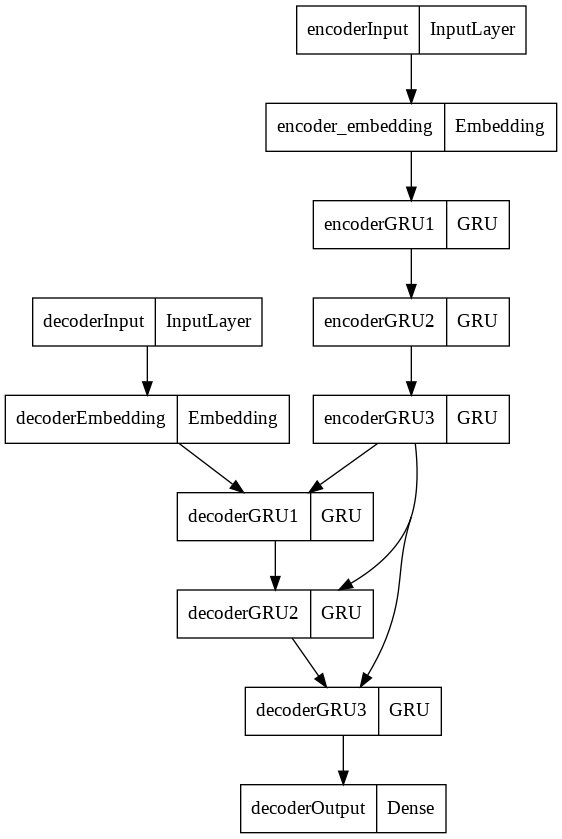

In [ ]:
tf.keras.utils.plot_model(
    modelTrain,
    to_file="model.png",
    show_shapes=False,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=False,
)


In [ ]:
modelTrain.compile(optimizer=RMSprop(learning_rate=1e-3),
                  loss='sparse_categorical_crossentropy')

In [ ]:
checkPath = '/content/drive/MyDrive/Machine Translation/21_checkpoint.h5'
checkPoint = ModelCheckpoint(filepath=checkPath,
                            monitor='val_loss',
                            verbose=1,
                            save_weights_only=True,
                            save_best_only=True)

stopping the optimization when performance worsens on the validation-set.

In [ ]:
earlyStop = EarlyStopping(monitor='val_loss',
                         patience=3,
                         verbose=1)

In [ ]:
callTensorBoard = TensorBoard(log_dir='./21_logs/',
                                   histogram_freq=0,
                                   write_graph=False)

In [ ]:
callBacks = [checkPoint,
            earlyStop,
            callTensorBoard]

### Load check point

In [ ]:
try:
    modelTrain.load_weights(checkPath)
    print('Weights Loaded')
except Exception as e:
    print('Error with loading weights')
    print(e)

Weights Loaded


### Training Model

In [ ]:
xData = {
    'encoderInput':encoderInputData,
    'decoderInput':decoderInputData
}

In [ ]:
yData= {
    'decoderOutput':decoderOutData
}

In [ ]:
validationSplit = 10000 / len(encoderInputData)
validationSplit

0.02031694433157253

In [ ]:
modelTrain.fit(x=xData,
               y=yData,
               epochs=10,
               batch_size=256, 
               validation_split=validationSplit,
 

Epoch 1/10
1884/1884 [==============================] - ETA: 0s - loss: 1.9814
Epoch 1: val_loss improved from inf to 1.80239, saving model to /content/drive/MyDrive/Machine Translation/21_checkpoint.h5
1884/1884 [==============================] - 705s 371ms/step - loss: 1.9814 - val_loss: 1.8024
Epoch 2/10
1884/1884 [==============================] - ETA: 0s - loss: 1.6219
Epoch 2: val_loss improved from 1.80239 to 1.65159, saving model to /content/drive/MyDrive/Machine Translation/21_checkpoint.h5
1884/1884 [==============================] - 718s 381ms/step - loss: 1.6219 - val_loss: 1.6516
Epoch 3/10
1884/1884 [==============================] - ETA: 0s - loss: 1.5000
Epoch 3: val_loss improved from 1.65159 to 1.57321, saving model to /content/drive/MyDrive/Machine Translation/21_checkpoint.h5
1884/1884 [==============================] - 717s 381ms/step - loss: 1.5000 - val_loss: 1.5732
Epoch 4/10
1884/1884 [==============================] - ETA: 0s - loss: 1.4268
Epoch 4: val_loss i

In [ ]:
def translateText(inputText , trueText=None):


  tokens = tokenizerSrc.text_to_tokens(inputText,
                                       reverse=True,
                                       padding=True)

  initialStates = modelEncoder.predict(tokens)


  maxTokens = tokenizerDest.maxTokens

  decoderInput = np.zeros(shape=(1,maxTokens))

  tokenInt = startToken

  tokensCount = 0

  translatedSentence = ""
  while tokenInt != endToken and tokensCount < maxTokens:


    decoderInput[0:tokensCount] = tokenInt

    xData = {
    'decoderInput':decoderInput,
    'decoderIntialState':initialStates
      }


    decoderOutput = decoderModel.predict(xData)

    tokenOneHot = decoderOutput[0,tokensCount,:]
    

    
    tokenInt = np.argmax(tokenOneHot)

    wordPredicted = tokenizerDest.token_to_word(tokenInt)



    translatedSentence += (" " + wordPredicted)

    tokensCount +=1


  print("Input text:")
  print(inputText)
  print()

  # Print the translated output-text.
  print("Translated text:")
  print(translatedSentence)
  print()

  # Optionally print the true translated text.
  if trueText is not None:
      print("True output text:")
      print(trueText)
      print()





In [ ]:
idx = 3
translateText(dataSrc[idx],dataDest[idx])

Input text:
De har udtrykt ønske om en debat om dette emne i løbet af mødeperioden.

Translated text:
 you have expressed a wish to this debate on this debate eeee

True output text:
ssss You have requested a debate on this subject in the course of the next few days, during this part-session. eeee



In [ ]:
idx = 2
translateText(dataSrc[idx],dataDest[idx])

Input text:
Som De kan se, indfandt det store "år 2000-problem" sig ikke. Til gengæld har borgerne i en del af medlemslandene været ramt af meget forfærdelige naturkatastrofer.

Translated text:
 you will be the population in 2000 but the population and you have been aware of the population and the population and the population has been able to 2000 and the population has been able to 2000 and the population has been able to 2000 and the most aware of the most aware of the most member

True output text:
ssss Although, as you will have seen, the dreaded 'millennium bug' failed to materialise, still the people in a number of countries suffered a series of natural disasters that truly were dreadful. eeee

